In [1]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import T5Model, T5ForConditionalGeneration, T5TokenizerFast
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install rouge-score
from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=d0c66c6981ae2d7201596e9610624a5f2801b10aaf19eb23475b8488ef18f8de
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import custom module

In [4]:
%cd /content/drive/MyDrive/ITMO/T5QA/src
%ls

/content/drive/MyDrive/ITMO/T5QA/src
medqadataset.py  __pycache__/  trainer.py


In [5]:
from medqadataset import MedQADataset
import trainer

In [ ]:
# For debugging
# import importlib
# importlib.reload(trainer)

In [6]:
#MODEL_NAME = "cointegrated/rut5-base"    # pre-trained model (first iteration)
MODEL_NAME = "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_generated"
TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME, local_files_only=True)
#TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME)
# Set up the T5 model
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
# Set up the optimizer
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)
Q_LEN = 512    # Question Length
T_LEN = 128    # Target Length
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
DEVICE

'cpu'

### Read Data

In [8]:
PATH = '/content/drive/MyDrive/ITMO/T5QA'

data = pd.read_csv(PATH + '/data/MedQuAD_generated_concat.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer
0,что такое кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами представляет...
1,сколько людей с шерстяными волосами страдают к...,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами встречается ...
2,"каковы генетические изменения, связанные с кер...",кератодермия с пушистыми волосами представляе...,"мутации в генах jup, dsp, dsc2 и kank2 вызываю..."
3,передается ли кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,большинство случаев кератодермии с курчавыми в...
4,что такое синдром кноблоха?,"синдром кноблоха редкое заболевание, характер...","синдром кноблоха редкое заболевание, характери..."
...,...,...,...
6401,что такое гипотония?,"g часов, а также часто нарушают сон. непроизво...",слабый мышечный тонус
6402,"какова основная причина дискинезии, связанной ...","у некоторых людей с дискинезией, связанной с a...",беспокойство
6403,"какова причина дискинезии, связанной с adcy5?","кинезия, в то время как у некоторых больных мо...",церебральный паралич или эпилепсия
6404,"какова причина дискинезии, связанной с adcy5?","название предполагает, что дискинезия, связанн...",ген adcy5


### Example

In [9]:
sample = data.iloc[5]
encoding = TOKENIZER(
    sample["question"],
    sample["context"],
    max_length=512,
    padding="max_length",
    truncation="only_second",
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt'
)

answer_encoding = TOKENIZER(
    sample["answer"],
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

labels = answer_encoding["input_ids"]

output = MODEL(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"],
    labels=labels
)

In [10]:
output.loss

tensor(111.2498, grad_fn=<NllLossBackward0>)

In [11]:
sample_q = data.iloc[5]["question"]
sample_a = data.iloc[5]["answer"]

sample_encoding = TOKENIZER(sample_q, sample_a)

In [12]:
sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
preds = [
    TOKENIZER.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    for input_id in sample_encoding["input_ids"]
]

In [14]:
" ".join(preds)

' сколько люд ей страда ет си ндром ом кн обл оха ?  си ндром кн обл оха ред кое заболевани е .  о днако  точная распростран енность это го заболевани я не известн а . '

### Dataloaders

In [15]:
train_data, test_data = train_test_split(data, test_size=0.02, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = MedQADataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, patience=5, verbose=True)

Train shape: (5021, 3)
Validation shape: (1256, 3)
Test shape: (129, 3)


### Train and validation loop

In [22]:
N_EPOCHS = 100
STATE_DICT_PATH = '/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_generated'

trainer_module = trainer.Trainer(
    MODEL,
    N_EPOCHS,
    STATE_DICT_PATH,
    train_loader,
    val_loader,
    OPTIMIZER,
    DEVICE,
    TOKENIZER,
    Q_LEN,
    T_LEN,
    scheduler
)

In [ ]:
trainer_module.fit()

Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 0		Train loss: 4.866450363093881		Validation loss: 1.8775795470377443


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 1		Train loss: 2.1765356440168278		Validation loss: 1.427905177994139


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.85it/s]


Epoch: 2		Train loss: 1.7474962549319693		Validation loss: 1.2752855351776073


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 3		Train loss: 1.5251138016913728		Validation loss: 1.1259613705288833


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.85it/s]


Epoch: 4		Train loss: 1.3679497574877209		Validation loss: 1.0477009084858713


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 5		Train loss: 1.2514842536276694		Validation loss: 0.9838888388435552


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.84it/s]


Epoch: 6		Train loss: 1.137383412071474		Validation loss: 0.8796128699449217


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 7		Train loss: 1.046581340787612		Validation loss: 0.8152051066896718


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 8		Train loss: 0.9605880539366014		Validation loss: 0.7537120898627931


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 9		Train loss: 0.8816988330666616		Validation loss: 0.7023627252145938


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.88it/s]


Epoch: 10		Train loss: 0.813910612919528		Validation loss: 0.6576440105701138


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 11		Train loss: 0.7473109771384839		Validation loss: 0.6006906653997625


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 12		Train loss: 0.704986712741102		Validation loss: 0.5437474203574809


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 13		Train loss: 0.6226510576352144		Validation loss: 0.49224821005941954


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 14		Train loss: 0.5665532192689883		Validation loss: 0.4531538990106742


Validation batches: 100%|██████████| 314/314 [01:20<00:00,  3.89it/s]


Epoch: 15		Train loss: 0.5212383884966231		Validation loss: 0.41027129582681093


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 16		Train loss: 0.4756844546842377		Validation loss: 0.36380756068025616


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 17		Train loss: 0.43235144283990284		Validation loss: 0.32252520715200883


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.88it/s]


Epoch: 18		Train loss: 0.399093813154621		Validation loss: 0.2937273466722316


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 19		Train loss: 0.3675294623830338		Validation loss: 0.27164185219177395


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 20		Train loss: 0.32903608693748676		Validation loss: 0.22058542639278111


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 21		Train loss: 0.3021584246986083		Validation loss: 0.19754296008521205


Training batches:  62%|██████▏   | 773/1256 [09:01<05:38,  1.43it/s]

### Evaluate results

In [23]:
test_sample = test_data.iloc[0]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"
test_answer = f"{test_sample['answer']}"

test_question

pred = trainer_module.predict_answer(
    test_context,
    test_question,
    test_answer,
    print_text=True
)

pred

Контекст: независимо от того, кормите ли вы ребенка грудным молоком, детской смесью или и тем, и другим, вам придется покупать бутылочки и соски. у вас есть большой выбор, поэтому может быть трудно понять, что купить. узнайте о различных вариантах и ​​о том, как ухаживать за бутылочками и сосками. как выбрать бутылочку и соску. тип соски и бутылочки, которые вы выберете, в основном будет зависеть от того, какой тип будет использовать ваш ребенок. некоторые дети предпочитают определенную форму соска, или при использовании определенных бутылочек у них может выделяться меньше газов. другие менее привередливы к определенным бутылкам. начинать
Вопрос: какой тип бутылочки и соски выбрать?
Ответ: какой тип соски будет в основном зависеть от того,


{'Reference Answer: ': 'какой тип соски будет в основном зависеть от того, какой тип будет использовать ваш ребенок',
 'Predicted Answer: ': 'Ответ: какой тип соски будет в основном зависеть от того,',
 'BLEU Score: ': {'google_bleu': 0.5862068965517241},
 'RougeL (precision): ': 0}

In [24]:
# Calculate metrics on test
bleu_avg, rouge_avg = trainer_module.calc_avg_metrics(test_data)
print("Test:")
print("BLEU:", bleu_avg)
print("RougeL:", rouge_avg)

Test:
BLEU: 0.6652164170527515
RougeL: 0.054325089208810136


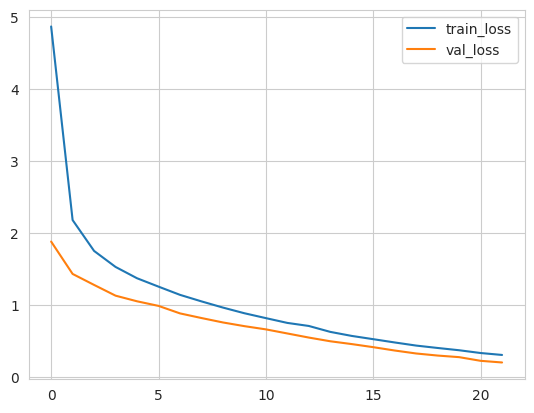

In [25]:
loss_filepath = "/content/drive/MyDrive/ITMO/T5QA/data/t5_MedQA_generated_loss_22.csv"
# Plot loss
trainer_module.plot_loss(filepath=loss_filepath)

### Inference

In [29]:
test_sample = test_data.iloc[20]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что такое увеит? также называется: ирит; парспланит; хориоидит; хориоретинит; передний увеит; задний увеит
Контекст: увеит это отек и воспаление сосудистой оболочки глаза. увеа это средний слой стенки глаза. увеа снабжает кровью радужную оболочку в передней части глаза и сетчатку в задней части глаза. причины увеит может быть вызван аутоиммунными заболеваниями. эти заболевания возникают, когда иммунная система организма по ошибке атакует и разрушает здоровые ткани организма. примеры: анкилозирующий спондилит болезнь бехчета псориаз реактивный артрит ревматоидный артрит саркоидоз язвенный колит увеит также может быть вызван такими инфекциями, как: спид цитомегаловирус цмв ретинит опоясывающий лишай гистоплазмоз болезнь кавасаки сифилис токсоплазмоз воздействие токсинов или травмы также могут вызвать увеит. во многих случаях причина неизвестна. часто воспаление ограничивается только частью сосудистой оболочки глаза. наиболее распространенная форма увеита включает воспаление раду

In [31]:
test_sample = test_data.iloc[18]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос: какие меры вы предпринимаете, чтобы помочь потушить пламя?
Контекст: вот эти шаги: оберните человека плотным материалом; например, шерстяное или хлопковое пальто, ковер или одеяло. это помогает потушить пламя. облейте человека водой. позвоните 911 или по местному номеру службы экстренной помощи. убедитесь, что человек больше не прикасается к горящим или дымящимся материалам. не снимайте обожженную одежду, прилипшую к коже. убедитесь, что человек дышит. при необходимости начните искусственное дыхание и сердечнолегочную реанимацию. накройте место ожога сухой стерильной повязкой при наличии или чистой тканью. лист подойдет, если
Ответ: заверните человека в плотный материал


In [28]:
test_sample = test_data.iloc[22]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос: какие анализы назначают при метаболическом ацидозе?
Контекст: зависят от основного заболевания или состояния. метаболический ацидоз сам по себе вызывает учащенное и глубокое дыхание, поскольку ваше тело пытается его компенсировать. также могут возникнуть спутанность сознания или вялость. тяжелый метаболический ацидоз может привести к шоку или смерти. симптомы респираторного ацидоза могут включать: спутанность сознания, утомляемость, летаргию, одышку, сонливость, осмотры и анализы. медицинский работник проведет медицинский осмотр и спросит о ваших симптомах. лабораторные анализы, которые могут быть назначены, включают: газы артериальной или венозной крови
Ответ: лабораторные тесты
